### Predict Sahel rainfall with linear regression

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

Here, we will try to **predict future** Sahel rainfall (lead times 1 / 3 / 6 months) from current information (t=0) of all input features (including PREC_SAHEL) with **linear regression** as baseline:

- Prepare inputs and targets.
- Set up model.
- Evaluate model performance.

### Nomenclature and mathematical background on linear regression

We apply multi-linear regression and use **all indices as predictors** to predict **Sahel precipitation anomaly index** with various lead times (1 / 3 / 6 months). 

Inputs have dimension (samples, features), targets have timension (samples, 1). We are looking for weights $W$ with shape (features, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the constant bias value.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including biases) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Import additional functions:
from predict_sahel_rainfall.plot import bar_color
from predict_sahel_rainfall.preprocessing import prepare_inputs_and_target

### Prepare inputs and targets, perform linear regression

Load collection of climate indices directly from GitHub release.
Use the complete preprocessing pipeline function.
**Note:** Don't need validation data, only need training and test data. Hence, set ```train_val_split = 1.0```.

In [15]:
## Set common parameters (except ESN and lead time):

# Set url to csv file containing CICMoD indices from desired release:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Select target index:
target_index = 'PREC_SAHEL'

# Select all input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# Choose, whether to add months as one-hot encoded features:
add_months = False

# Choose, whether to normalize target index:
norm_target = True

# Specify input length:
input_length = 1

# Specify amount of combined training and validation data relative to test data:
train_test_split = 0.9

# Specify relative amount of combined training and validation used for training:
train_val_split = 1.0

## Optionally choose to scale or normalize input features according to statistics from training data:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'norm'

In [93]:
# Set choice of ESMs:
ESMs = ['CESM', 'FOCI']

# Set choice of lead times:
lead_times = [1,3,6]

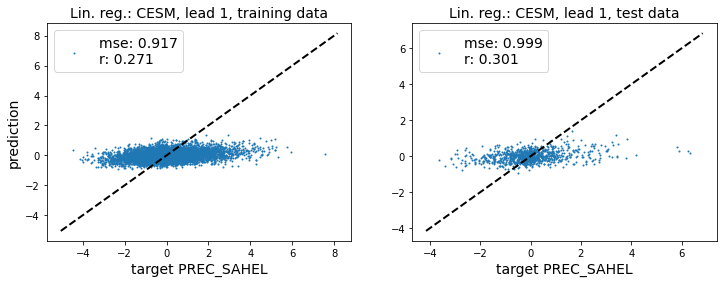

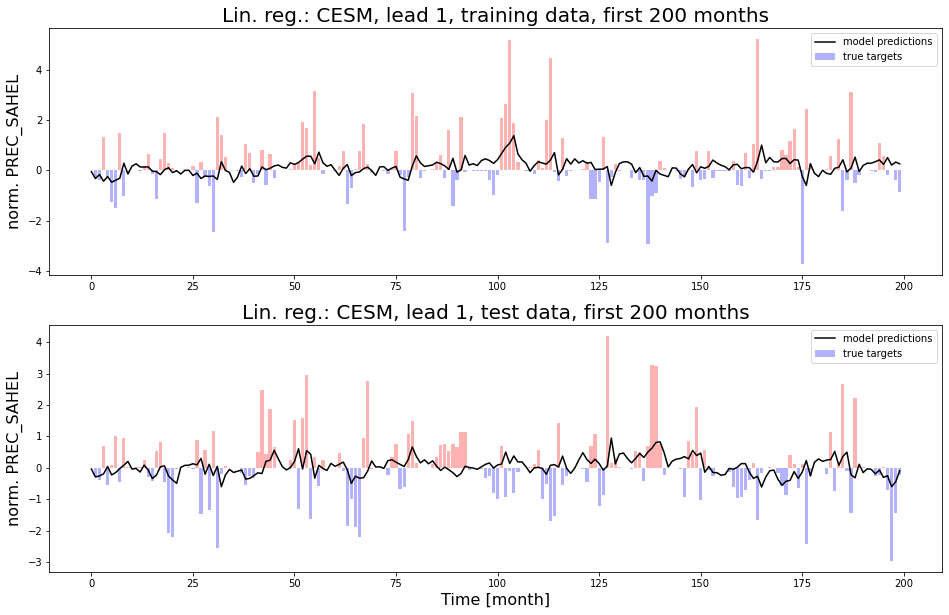

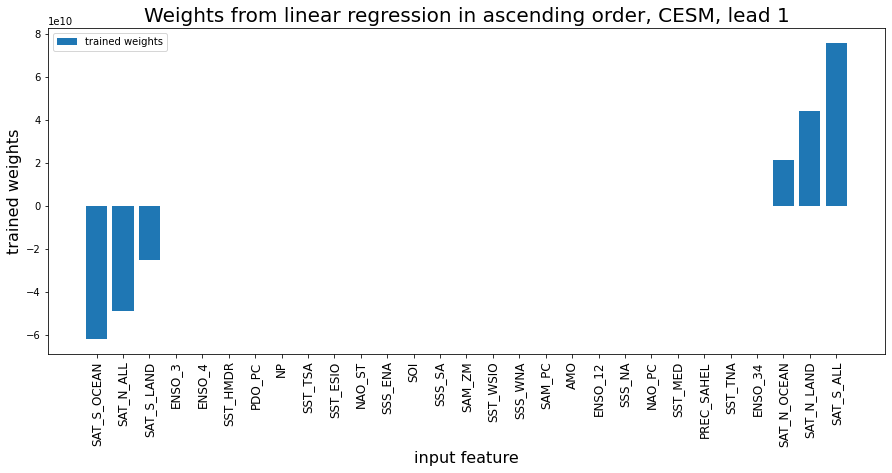

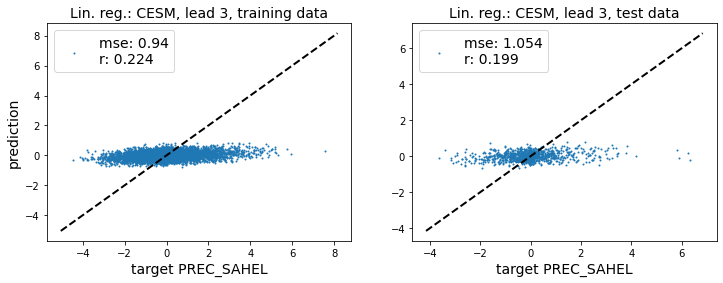

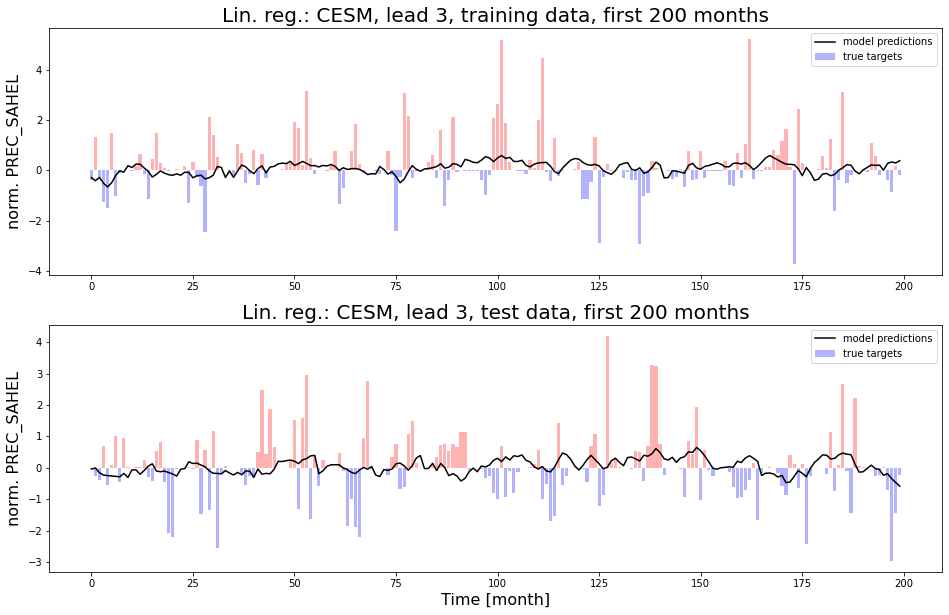

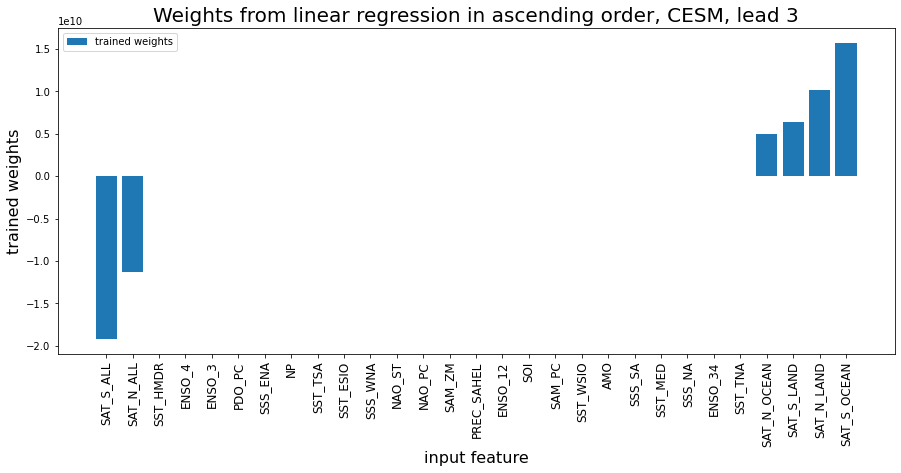

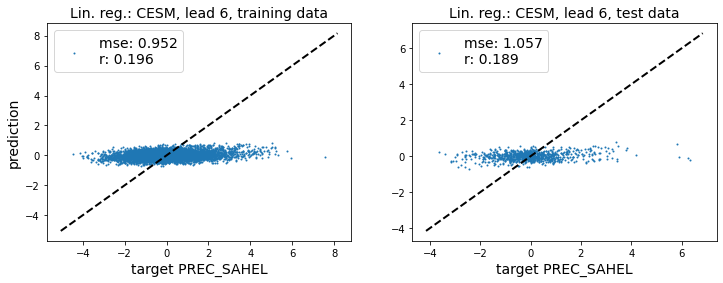

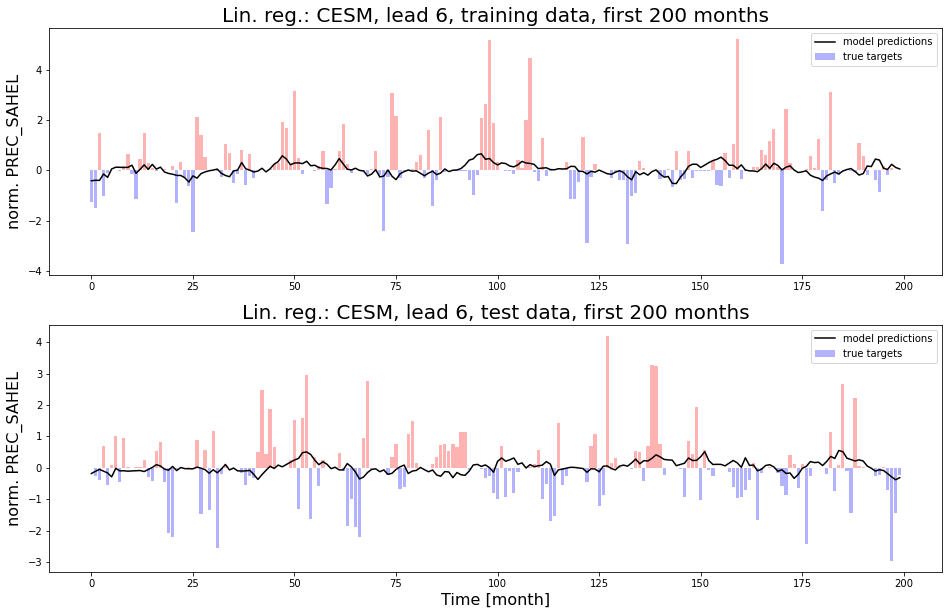

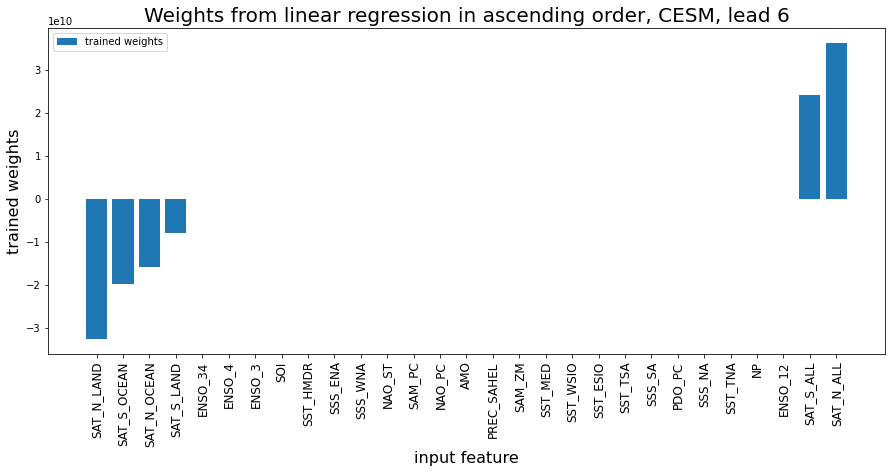

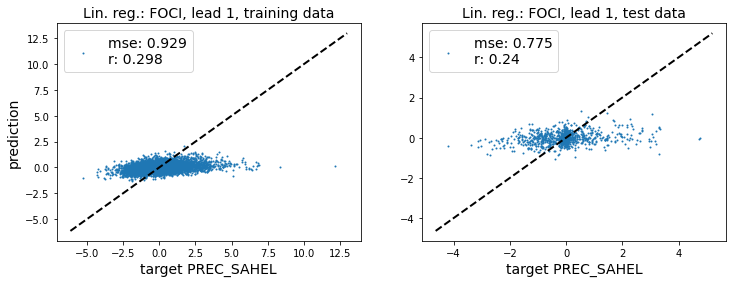

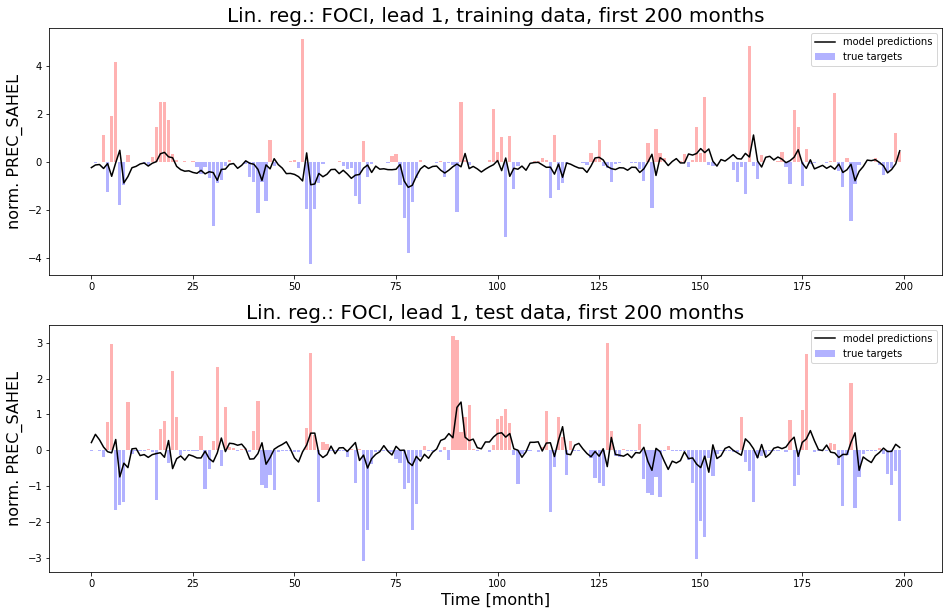

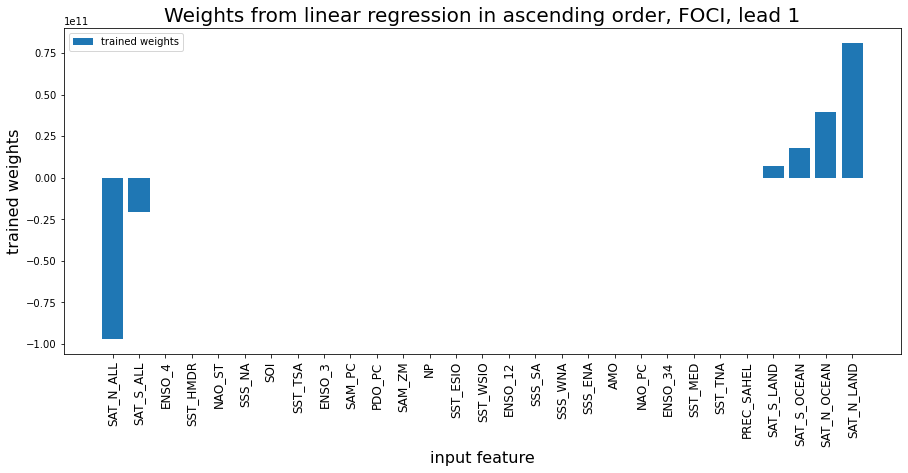

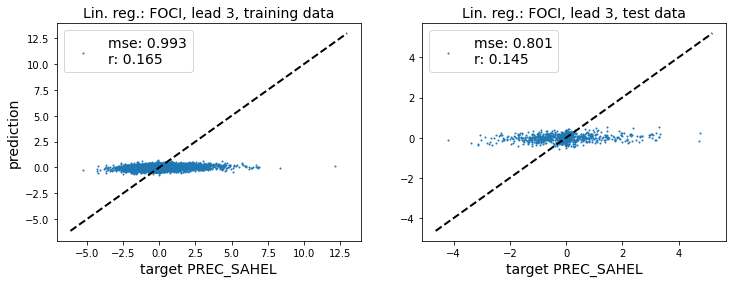

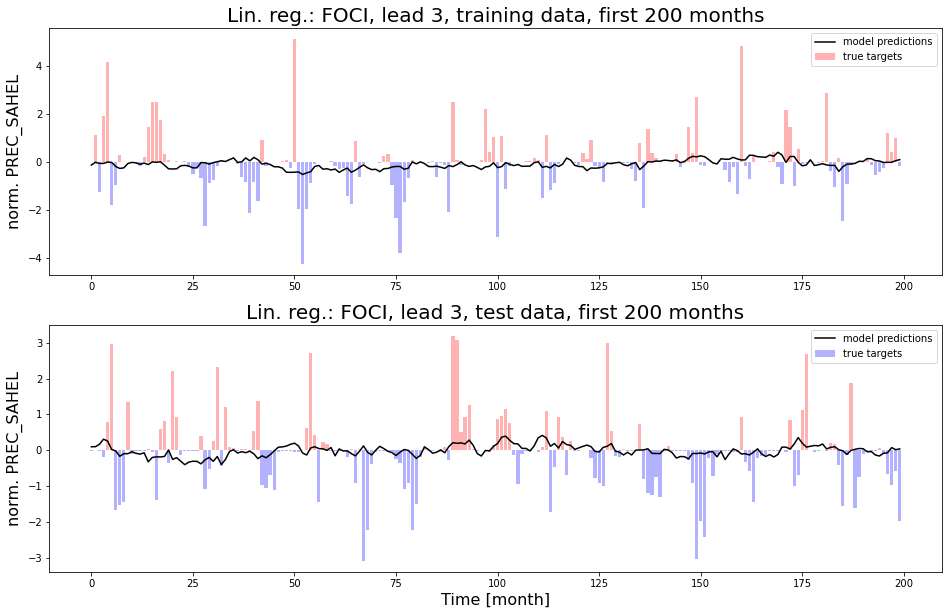

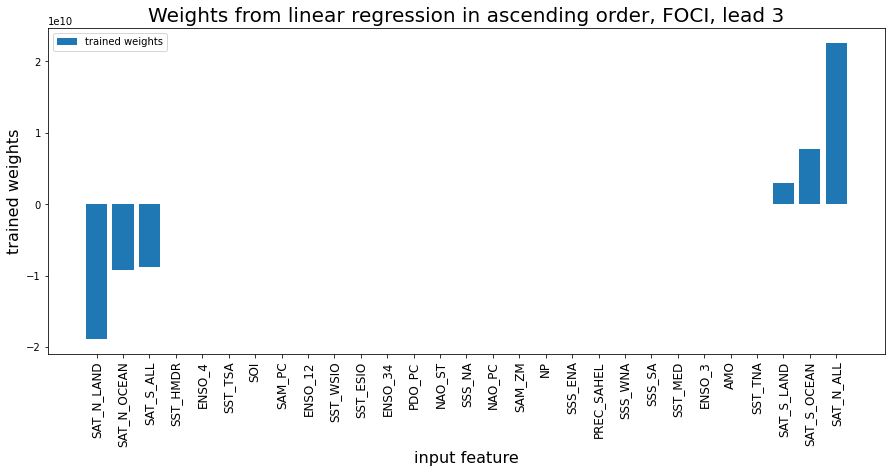

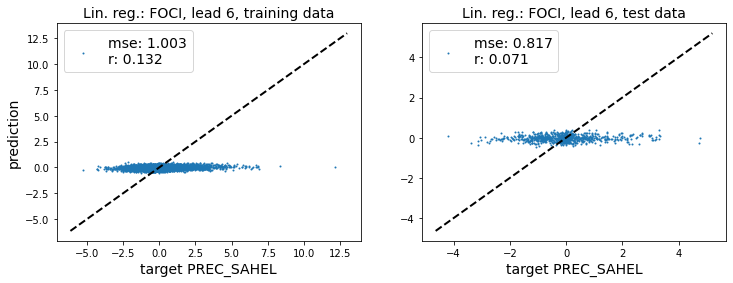

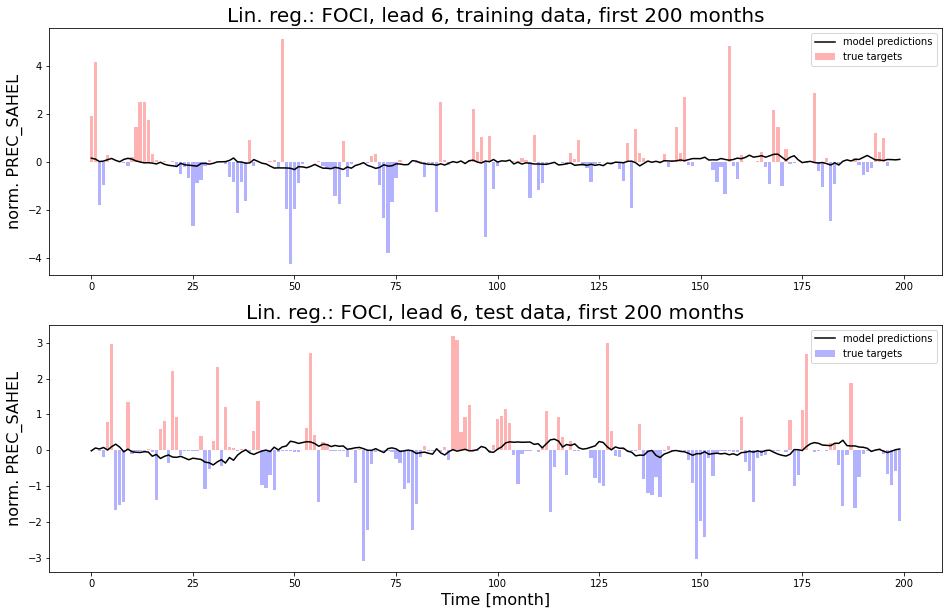

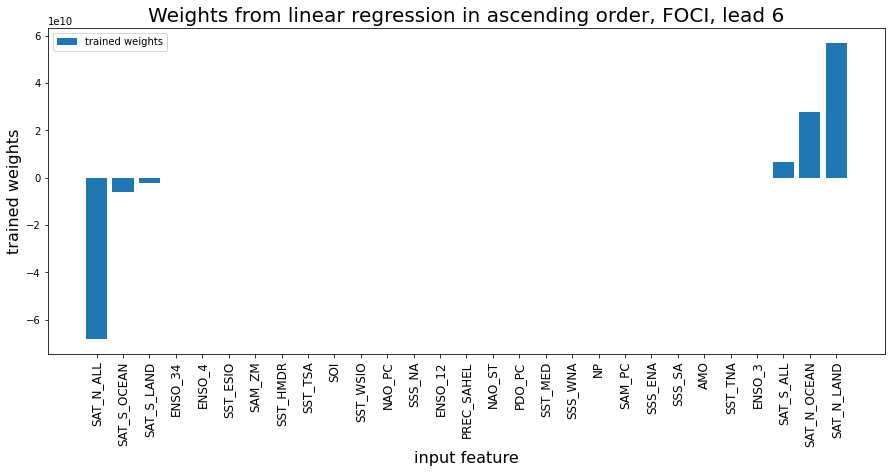

In [94]:
## Loop over ESNs:
for e in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[e]

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            _,
            _,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Omit time steps (=1) as separate dimension in training and test inputs.
        # Only need dimensions (samples, features):
        train_input = np.squeeze(train_input, axis=1)
        test_input = np.squeeze(test_input, axis=1)
        
        # Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and test inputs.
        train_input_add = np.ones((train_input.shape[0], 1))
        test_input_add = np.ones((test_input.shape[0], 1))

        # Now add vector of ONEs as additional column to train and test inputs, omit time dimension:
        train_input_prime = np.concatenate((train_input, train_input_add), axis=-1)
        test_input_prime = np.concatenate((test_input, test_input_add), axis=-1)

        # Then need pseudo-inverse of train inputs in augmented notation:
        train_input_prime_inv = np.linalg.pinv(train_input_prime)

        # Train weights targets with current lead time:
        W_prime = np.matmul(train_input_prime_inv, train_target)    

        # Extract weights and bias from augmented notation (W_prime), the last value is the bias:
        W = W_prime[:-1]    

        # Get model predictions on train and validation data:
        train_pred = np.matmul(train_input_prime, W_prime)
        test_pred = np.matmul(test_input_prime, W_prime)

        ## Show scatterplot of Sahel rainfall obtained from model predictions vs. true targets.

        # Initialize plot:
        fig, axes = plt.subplots(1,2,figsize=(12,4))

        # Training data:
        axes[0].scatter(train_target, train_pred, s=1,
                       label='mse: '+
                        str(np.round(np.mean((train_target - train_pred)**2),3))+'\nr: '+
                        str(np.round(np.corrcoef(np.squeeze(np.stack([train_target,train_pred]),axis=-1))[0,1],3))
                       )
        axes[0].legend(fontsize=14)
        axes[0].set_title('Lin. reg.: '+ESM+', lead '+str(lead_time)+', training data', fontsize=14)
        axes[0].set_xlabel('target PREC_SAHEL', fontsize=14)
        axes[0].set_ylabel('prediction', fontsize=14)

        x = np.linspace(*axes[0].get_xlim())
        axes[0].plot(x, x, linestyle='--', color='k', lw=2)

        # Test data:
        axes[1].scatter(test_target, test_pred, s=1,
                       label='mse: '+
                        str(np.round(np.mean((test_target - test_pred)**2),3))+'\nr: '+
                        str(np.round(np.corrcoef(np.squeeze(np.stack([test_target,test_pred]),axis=-1))[0,1],3))
                       )
        axes[1].legend(fontsize=14)
        axes[1].set_title('Lin. reg.: '+ESM+', lead '+str(lead_time)+', test data', fontsize=14)
        axes[1].set_xlabel('target PREC_SAHEL', fontsize=14)
        #axes[1].set_ylabel('prediction', fontsize=14)

        x = np.linspace(*axes[1].get_xlim())
        axes[1].plot(x, x, linestyle='--', color='k', lw=2)
        
        ## Fidelity check: Plot targets as bar plot (red / blue) vs. predictions as black line

        # Limit the plot to showing the first xx time steps:
        time_steps = 200

        # Initialize plot:
        fig, axes = plt.subplots(2,1,figsize=[16,10])

        # Training data:
        axes[0].bar(
            x=range(time_steps),
            height=train_target[:time_steps,0],
            color=bar_color(train_target[:time_steps],'r','b')[:,0],
            label="true targets",
            alpha=0.3
        )

        axes[0].plot(train_pred[:time_steps,0], label="model predictions", color='black')
        axes[0].legend()

        axes[0].set_title('Lin. reg.: '+ESM+', lead '+str(lead_time)+', training data, first '+str(time_steps)+' months', fontsize=20)
        axes[0].set_ylabel('norm. PREC_SAHEL', fontsize=16)

        #axes[0].set_xlabel('Time [month]', fontsize=16)

        # Test data:
        axes[1].bar(
            x=range(time_steps),
            height=test_target[:time_steps,0],
            color=bar_color(test_target[:time_steps],'r','b')[:,0],
            label="true targets",
            alpha=0.3
        )

        axes[1].plot(test_pred[:time_steps,0], label="model predictions", color='black')
        axes[1].legend()

        axes[1].set_title('Lin. reg.: '+ESM+', lead '+str(lead_time)+', test data, first '+str(time_steps)+' months', fontsize=20)
        axes[1].set_ylabel('norm. PREC_SAHEL', fontsize=16)

        axes[1].set_xlabel('Time [month]', fontsize=16)
        
        ## Plot trained weights in ascending order:

        # Initialize plot:
        fig, ax = plt.subplots(1,1,figsize=[15,6])
        ax.bar(
            x=range(len(W)),
            height=W[:,0][np.argsort(W[:,0])],
            label="trained weights",
        )
        ax.legend()
        ax.set_title('Weights from linear regression in ascending order, '+ESM+', lead '+str(lead_time), fontsize=20)
        ax.set_xlabel('input feature', fontsize=16)
        ax.set_ylabel('trained weights', fontsize=16)
        plt.xticks(range(len(W)), np.array(input_features)[np.argsort(W[:,0])], fontsize=12, rotation=90)

### Discussion: Linear regression results

In this experiment, we allowed historic information for PREC_SAHEL as input feature to predict future Sahel precipitation (lead 1 / 3 / 6 months).

We have a low level of auto correlation between original PREC_SAHEL index and targets (lead 1 / 3 / 6 months). Only for lead time 1 months, we have a small correlation of 0.2.

This reflects in the results: We get only poor results from linear regression on this highly non-linear problem, especially for lead times > 1.